This pipeline retrieves significant DEGs and perform appropriate filters to generate biologically relevant expression changing gene sets.

Filter set is:
- log2 FC > 1.
- min max expression > 2 TPM
- noise threshold > 0.5


In [1]:
import pandas, numpy, matplotlib_venn

In [ ]:
import sklearn, sklearn.decomposition, sklearn.preprocessing

In [65]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

# 0. user-defined variables

In [3]:
DEG_folder = '/home/adrian/projects/reynisfjara/results/DEGs_DESeq2/'
expression_file = '/home/adrian/projects/reynisfjara/results/tpm/DESeq2_TPM_values.tsv'
annotation_file = '/home/adrian/projects/reynisfjara/results/annotation/annotation.csv'
results_table_dir = '/home/adrian/projects/reynisfjara/results/relevant_DEGs/'

mice = ['a3922', 'a4774', 'a4775', 'a4776']
trends = ['up', 'down']

expression_threshold = 2
discrete_fc_threshold = 1
noise_threshold = 1/2

# 1. read data

## 1.1. expression data

In [4]:
expression = pandas.read_csv(expression_file, sep='\t', index_col=0)
expression.head()

,a3922_0h_1,a3922_0h_2,a3922_0h_3,a3922_48h_1,a3922_48h_2,a3922_48h_3,a3922_72h_1,a3922_72h_2,a3922_72h_3,a4774_0h_1,...,a4775_72h_3,a4776_0h_1,a4776_0h_2,a4776_0h_3,a4776_48h_1,a4776_48h_2,a4776_48h_3,a4776_72h_1,a4776_72h_2,a4776_72h_3
ENSMUSG00000000001,65.244411,65.953285,64.396929,75.289955,71.147817,72.146832,67.786762,70.217188,70.219265,61.227221,...,68.440778,64.806231,65.619286,66.749396,64.425407,68.665136,68.419059,69.705546,70.717428,71.017699
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.945436,5.464240,4.924612,20.245428,19.780706,22.747363,19.239938,22.062649,20.547492,7.843197,...,14.565935,4.712688,3.690099,4.120889,7.220914,8.377850,9.611563,9.465468,10.235803,9.808747
ENSMUSG00000000037,0.220972,0.959207,0.258270,0.969948,1.149452,2.212842,0.989879,2.354492,1.813624,0.545637,...,0.989086,0.451844,0.523639,0.679725,2.862086,0.865126,1.973570,1.612622,2.148935,5.445061
ENSMUSG00000000049,0.061451,0.061879,0.096945,0.000000,0.071373,0.000000,0.059768,0.000000,0.000000,0.214027,...,0.761343,0.000000,0.125876,0.000000,0.000000,0.096454,0.130578,0.000000,0.000000,0.000000


## 1.2. annotation

In [5]:
annotation = pandas.read_csv(annotation_file, sep=',', index_col='ens_gene')
annotation.drop(columns=['Unnamed: 0', 'target_id'], inplace=True)
annotation.drop_duplicates(inplace=True)
print(annotation.shape)
annotation.head()

(53193, 3)


,gene_biotype,description,ext_gene
ens_gene,,,
ENSMUSG00000064336,Mt_tRNA,mitochondrially encoded tRNA phenylalanine [So...,mt-Tf
ENSMUSG00000064337,Mt_rRNA,mitochondrially encoded 12S rRNA [Source:MGI S...,mt-Rnr1
ENSMUSG00000064338,Mt_tRNA,mitochondrially encoded tRNA valine [Source:MG...,mt-Tv
ENSMUSG00000064339,Mt_rRNA,mitochondrially encoded 16S rRNA [Source:MGI S...,mt-Rnr2
ENSMUSG00000064340,Mt_tRNA,mitochondrially encoded tRNA leucine 1 [Source...,mt-Tl1


In [6]:
annotation.head()

,gene_biotype,description,ext_gene
ens_gene,,,
ENSMUSG00000064336,Mt_tRNA,mitochondrially encoded tRNA phenylalanine [So...,mt-Tf
ENSMUSG00000064337,Mt_rRNA,mitochondrially encoded 12S rRNA [Source:MGI S...,mt-Rnr1
ENSMUSG00000064338,Mt_tRNA,mitochondrially encoded tRNA valine [Source:MG...,mt-Tv
ENSMUSG00000064339,Mt_rRNA,mitochondrially encoded 16S rRNA [Source:MGI S...,mt-Rnr2
ENSMUSG00000064340,Mt_tRNA,mitochondrially encoded tRNA leucine 1 [Source...,mt-Tl1


# 2. define gene sets

In [7]:
log_file = 'messages.deseq2.filter.txt'
log = open(log_file, 'w')

for mouse in mice:
    condition_labels0 = ['{}_0h_{}'.format(mouse, i+1) for i in range(3)]
    condition_labels48 = ['{}_48h_{}'.format(mouse, i+1) for i in range(3)]
    condition_labels72 = ['{}_72h_{}'.format(mouse, i+1) for i in range(3)]
    
    for trend in trends:
        log.write('working with mouse {} and trend {}'.format(mouse, trend))
        
        container = []
        
        DEG_file = DEG_folder + mouse + '_' + trend + '.tsv'
        DEGs = pandas.read_csv(DEG_file, sep='\t', index_col=0)
        log.write('\t detected {} DEGs'.format(DEGs.shape[0]))
        
        rules = (DEGs['pvalue'] < 0.05) & (DEGs['padj'] < 0.1)
        sub = DEGs[rules]
        log.write('\t passed tests {}'.format(DEGs.shape[0]))
        
        for ensembl in DEGs.index:
            
            gene_name = ''; biotype = ''; description = ''
            try:
                gene_name = annotation.loc[ensembl]['ext_gene']
                biotype = annotation.loc[ensembl]['gene_biotype']
                description = annotation.loc[ensembl]['description'].split(' [')[0]
            except:
                pass
            
            log.write('\t\t working with {} ({})'.format(ensembl, gene_name))
            including = True
            
            #
            # filter 1 --- expression
            #
            tpms0 = []
            for label in condition_labels0:
                if label in expression.keys():
                    tpms0.append(expression[label][ensembl])
            tpm0 = numpy.median(tpms0)
            tpms48 = []
            for label in condition_labels48:
                if label in expression.keys():
                    tpms48.append(expression[label][ensembl])
            tpm48 = numpy.median(tpms48)
            tpms72 = []
            for label in condition_labels72:
                if label in expression.keys():
                    tpms72.append(expression[label][ensembl])
            tpm72 = numpy.median(tpms72)
            top = numpy.max([tpm0, tpm48, tpm72])
            
            #
            # filter 2 --- identify fold-changes using discrete values
            #        
            ###'_deseq2_'
            ###            [round(x, epsilon)/epsilon ] + 1
            ###  FC = abs  -------------------------------- > 1
            ###            [round(y, epsilon)/epsilon ] + 1
            ###
            ###
            ###  epsilon = 1
            sam48 = numpy.around(tpm48) + 1
            sam72 = numpy.around(tpm72) + 1
            ref = numpy.around(tpm0) + 1
            
            fc48 = sam48/ref; fc72 = sam72/ref
            log2FC48 = numpy.log2(fc48); log2FC72 = numpy.log2(fc72)
            
            #
            # filter 3 --- noise
            #
            tpms0_int = numpy.around(tpms0) + 1
            rsem_tpms0 = numpy.std(tpms0_int) / (numpy.sqrt(len(tpms0_int)) * numpy.mean(tpms0_int))
            
            tpms48_int = numpy.around(tpms48) + 1
            rsem_tpms48 = numpy.std(tpms48_int) / (numpy.sqrt(len(tpms48_int)) * numpy.mean(tpms48_int))
            
            tpms72_int = numpy.around(tpms72) + 1
            rsem_tpms72 = numpy.std(tpms72_int) / (numpy.sqrt(len(tpms72_int)) * numpy.mean(tpms72_int))
            noise = numpy.mean([rsem_tpms0, rsem_tpms48, rsem_tpms72])
            
            #
            # selection
            #
            if top < expression_threshold:
                including = False
                info = '\t\t\t WARNING: low-expression gene discarded. Expression changes from {:.3f} to {:.3f} and {:.3f}'.format(tpm0, tpm48, tpm72)
                log.write(info)
                
            if (including == True):
                # check that trend is consistent in both timepoints
                if (log2FC48*log2FC72) < 0:
                    including = False
                    info = '\t\t\t WARNING: inconsistent trend: {:.3f} and {:.3f}'.format(log2FC48, log2FC72)
                    log.write(info)
                # check that you are abs log2FC > 1 at both conditions
                if numpy.max([numpy.abs(log2FC48), numpy.abs(log2FC72)]) < 1:
                    including = False
                    info = '\t\t\t WARNING: small change gene discarded: Expressions: {:.2f}, {:.2f}, {:.2f}. Fold changes: {:.2f}, {:.2f}'.format(tpm0, tpm48, tpm72, log2FC48, log2FC72)
                    log.write(info)
                    
            if (including == True) and (noise > noise_threshold):
                including = False
                info = '\t\t\t WARNING: noisy gene discarded.'
                log.write(info)
            
            #
            # store DEGs that passed filters
            #
            if including == True:
                log.write('\t\t\t SUCCESS: expression: [{:.3f}, {:.3f}, {:.3f}]; log2FCs: [{:.2f}, {:.2f}]'.format(tpm0, tpm48, tpm72, log2FC48, log2FC72))
                print
                accumulative_expression_difference = numpy.log10(numpy.abs(tpm72-tpm0) + numpy.abs(tpm48-tpm0))
                accumulative_fold_change = log2FC48 + log2FC72
                
                box = [ensembl, gene_name, biotype, description, '{:.2f}'.format(tpm0), '{:.2f}'.format(tpm48), '{:.2f}'.format(tpm72), '{:.3f}'.format(log2FC48), '{:.3f}'.format(log2FC72), '{:.3f}'.format(accumulative_expression_difference), '{:.3f}'.format(accumulative_fold_change)]
                container.append(box)
                
        #
        # info about selection
        #
        log.write('\t pased filters {}\n'.format(len(container)))
        
        #print
        # store results
        #
        results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
        f = open(results_table_file, 'w')
        f.write('ENSEMBL\tGene name\tBiotype\tDescription\tTPM @ T0\tTPM @ T48\tTPM @T72\tlog2FC @ T48\tlog2TPM @ T72\tAccumulative expression difference (log10 TPM)\tAccumulative log2FC\n')
        for box in container:
            info = '\t'.join(box)
            info = info + '\n'
            f.write(info)
        f.close()        
        
log.close()

# 3. find intersect

## 3.1. find intersect across up/down mutants

72


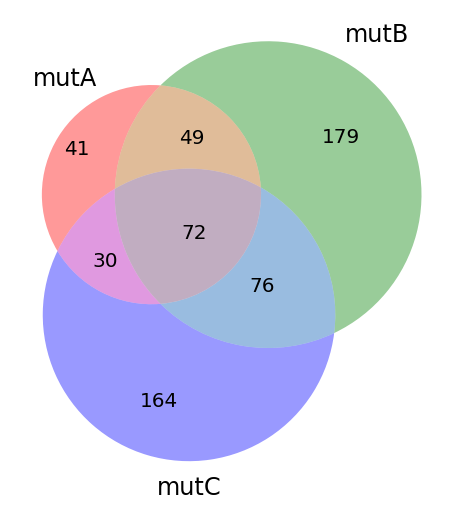

In [8]:
# up
trend = 'up'
all_degs = []
for mouse in mice[1:]:
    results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
    df = pandas.read_csv(results_table_file, sep='\t', index_col=0)
    degs = df.index.to_list()
    all_degs.append(set(degs))
    
# Venn diagram
matplotlib_venn.venn3(all_degs, set_labels=('mutA', 'mutB', 'mutC'))

# define core
core_mut_up = list(all_degs[0] & all_degs[1] & all_degs[2])
print(len(core_mut_up))

54


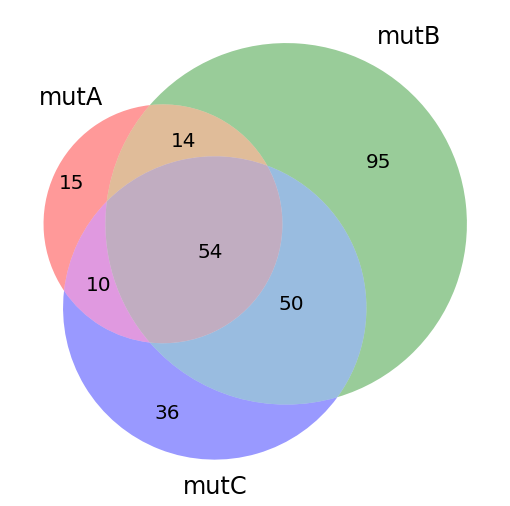

In [9]:
# down
trend = 'down'
all_degs = []
for mouse in mice[1:]:
    results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
    df = pandas.read_csv(results_table_file, sep='\t', index_col=0)
    degs = df.index.to_list()
    all_degs.append(set(degs))
    
# Venn diagram
matplotlib_venn.venn3(all_degs, set_labels=('mutA', 'mutB', 'mutC'))

# define core
core_mut_down = list(all_degs[0] & all_degs[1] & all_degs[2])
print(len(core_mut_down))

## 3.2. find the intersect between WT and mutant phenotypes

602


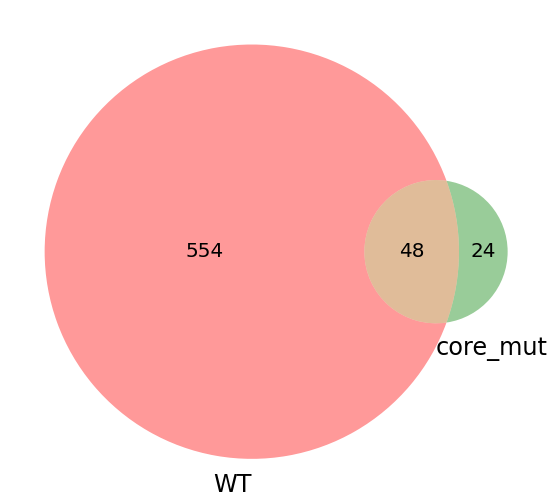

In [10]:
# up
trend = 'up'
mouse = 'a3922'
all_degs = []

results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
df = pandas.read_csv(results_table_file, sep='\t', index_col=0)
wt_up = set(df.index.to_list())
print(len(wt_up))
    
# Venn diagram
matplotlib_venn.venn2([wt_up, set(core_mut_up)], set_labels=('WT', 'core_mut'))

In [16]:
index = 0
for element in core_mut_up:
    if element not in wt_up:
        index = index + 1
        gene_name = annotation.loc[element]['ext_gene']
        description = annotation.loc[element]['description'].split(' [')[0]
        print(index, element, gene_name, description)

1 ENSMUSG00000028713 Cyp4b1 cytochrome P450, family 4, subfamily b, polypeptide 1
2 ENSMUSG00000022676 Snai2 snail family zinc finger 2
3 ENSMUSG00000030796 Tead2 TEA domain family member 2
4 ENSMUSG00000015467 Egfl8 EGF-like domain 8
5 ENSMUSG00000047793 Sned1 sushi, nidogen and EGF-like domains 1
6 ENSMUSG00000020648 Dus4l dihydrouridine synthase 4-like (S. cerevisiae)
7 ENSMUSG00000029605 Oas1b 2'-5' oligoadenylate synthetase 1B
8 ENSMUSG00000037621 Atoh8 atonal bHLH transcription factor 8
9 ENSMUSG00000016496 Cd274 CD274 antigen
10 ENSMUSG00000073805 Insyn2a inhibitory synaptic factor 2A
11 ENSMUSG00000006235 Epor erythropoietin receptor
12 ENSMUSG00000085684 4930469K13Rik RIKEN cDNA 4930469K13 gene
13 ENSMUSG00000021806 Nid2 nidogen 2
14 ENSMUSG00000052468 Pmp2 peripheral myelin protein 2
15 ENSMUSG00000083257 Gm15568 predicted gene 15568
16 ENSMUSG00000003617 Cp ceruloplasmin
17 ENSMUSG00000038816 Ctnnal1 catenin (cadherin associated protein), alpha-like 1
18 ENSMUSG00000041828 A

295


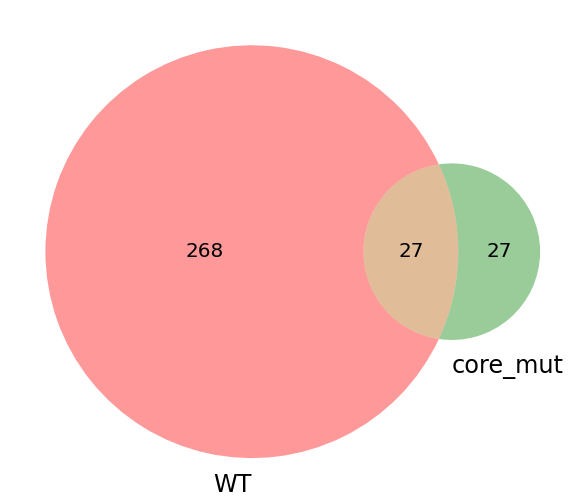

In [12]:
# down
trend = 'down'
mouse = 'a3922'
all_degs = []

results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
df = pandas.read_csv(results_table_file, sep='\t', index_col=0)
wt_down = set(df.index.to_list())
print(len(wt_down))
    
# Venn diagram
matplotlib_venn.venn2([wt_down, set(core_mut_down)], set_labels=('WT', 'core_mut'))

In [15]:
index = 0
for element in core_mut_down:
    if element not in wt_down:
        index = indexCd63 mitf + 1
        gene_name = annotation.loc[element]['ext_gene']
        description = annotation.loc[element]['description'].split(' [')[0]
        print(index, element, gene_name, description)

1 ENSMUSG00000023009 Nckap5l NCK-associated protein 5-like
2 ENSMUSG00000013653 1810065E05Rik RIKEN cDNA 1810065E05 gene
3 ENSMUSG00000021696 Elovl7 ELOVL family member 7, elongation of long chain fatty acids (yeast)
4 ENSMUSG00000078670 Fam174b family with sequence similarity 174, member B
5 ENSMUSG00000035273 Hpse heparanase
6 ENSMUSG00000046727 Cystm1 cysteine-rich transmembrane module containing 1
7 ENSMUSG00000046352 Gjb2 gap junction protein, beta 2
8 ENSMUSG00000037049 Smpd1 sphingomyelin phosphodiesterase 1, acid lysosomal
9 ENSMUSG00000015766 Eps8 epidermal growth factor receptor pathway substrate 8
10 ENSMUSG00000021998 Lcp1 lymphocyte cytosolic protein 1
11 ENSMUSG00000022353 Mtss1 MTSS I-BAR domain containing 1
12 ENSMUSG00000004651 Tyr tyrosinase
13 ENSMUSG00000025351 Cd63 CD63 antigen
14 ENSMUSG00000040606 Kazn kazrin, periplakin interacting protein
15 ENSMUSG00000050390 C77080 expressed sequence C77080
16 ENSMUSG00000068220 Lgals1 lectin, galactose binding, soluble 1
17 

# 4. PCA on DEGs

In [ ]:
mice = ['a3922', 'a4774', 'a4775', 'a4776']
trends = ['up', 'down']

In [23]:
all_degs = []
for mouse in mice:
    for trend in trends:
        results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
        df = pandas.read_csv(results_table_file, sep='\t', index_col=0)
        elements = df.index.to_list()
        all_degs.append(elements)
        print(len(elements))

602
295
192
93
376
213
342
150


In [28]:
results_union = list(set().union(*all_degs))
print(len(results_union))

1398


In [43]:
selected = expression.loc[results_union, :]
transpose = selected.transpose()
pca_tpms = numpy.log2(transpose + 1)
print(pca_tpms.shape)
pca_tpms.head()

(35, 1398)


,ENSMUSG00000002055,ENSMUSG00000040690,ENSMUSG00000031737,ENSMUSG00000002900,ENSMUSG00000027329,ENSMUSG00000022209,ENSMUSG00000049858,ENSMUSG00000022322,ENSMUSG00000021281,ENSMUSG00000015766,...,ENSMUSG00000005986,ENSMUSG00000032172,ENSMUSG00000034773,ENSMUSG00000078317,ENSMUSG00000021697,ENSMUSG00000020493,ENSMUSG00000040714,ENSMUSG00000050106,ENSMUSG00000022371,ENSMUSG00000023990
a3922_0h_1,2.378475,4.271343,4.863763,4.644019,2.371720,0.572020,4.807159,2.327075,3.224344,8.708996,...,2.069759,1.612692,1.649439,4.243166,0.959997,2.267499,2.015656,2.007774,3.484854,5.473823
a3922_0h_2,2.387813,4.015202,4.773026,4.949977,2.330117,0.578796,4.907499,2.435671,2.778312,9.020626,...,1.766865,1.637883,1.748410,4.263128,1.089456,2.383277,1.828499,2.014299,3.563534,5.023205
a3922_0h_3,2.407696,3.876772,4.752992,4.972406,2.417230,0.205601,4.995185,2.168650,3.211535,8.848125,...,1.651879,1.943012,1.342480,4.280548,1.457086,2.454205,1.647455,2.377018,3.578433,5.130923
a3922_48h_1,4.072800,3.733061,4.008649,5.707866,3.096235,1.774066,3.945598,4.512369,4.025781,8.232572,...,2.009166,3.159143,3.097420,3.323636,2.592600,3.973476,1.057726,3.274859,4.189220,3.606064
a3922_48h_2,4.097606,1.911770,4.051524,5.704689,3.212402,1.749533,3.765134,4.667058,3.870005,8.160802,...,2.140018,3.194886,2.981796,3.311924,2.848399,3.968028,1.178669,3.450277,4.183364,3.850083


In [35]:
import sklearn, sklearn.decomposition, sklearn.preprocessing

In [55]:
100

array([[-30.62524908, -14.88755939],
       [-26.05259115, -15.56817772],
       [-29.45175562, -13.99959141],
       [ 36.98727758, -18.83061446],
       [ 36.95348357, -19.35352085],
       [ 40.72853639, -15.32910278],
       [ 38.10336776, -13.62948356],
       [ 37.61132117, -15.08658162],
       [ 38.53958798, -14.47790362],
       [-24.42378845,  -3.12280919],
       [-25.97041707,  -5.75703377],
       [-25.45848636,  -5.83003669],
       [ -1.85772441,  15.33231232],
       [ -9.90894919,  10.92102725],
       [  1.975013  ,  10.37289264],
       [  4.52793097,  17.43677508],
       [  7.59714528,  15.40833295],
       [-30.34613106, -19.72377451],
       [-27.62766958, -17.19524183],
       [-25.51127873, -18.96830589],
       [ 21.4970109 ,  -4.04258244],
       [ 24.38052384,  -2.86158442],
       [ 16.64074534,  -0.82260572],
       [ 25.15595837,   1.98867399],
       [ 24.92029604,   3.43779747],
       [ 21.52570828,   3.35570554],
       [-38.9023027 ,  -3.20037252],
 

In [78]:
scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(pca_tpms)
model = sklearn.decomposition.PCA(n_components=2)
new = model.fit_transform(scaled_data)
explained = model.explained_variance_ratio_

In [88]:
the_colors = []
for element in pca_tpms.index:
    if mice[0] in element:
        the_colors.append('black')
    elif mice[1] in element:
        the_colors.append('tab:red')
    elif mice[2] in element:
        the_colors.append('tab:orange')
    elif mice[3] in element:
        the_colors.append('gold')
    else:
        print('error')
        
the_markers = []
for element in pca_tpms.index:
    if '0h' in element:
        the_markers.append('o')
    elif '48h' in element:
        the_markers.append('v')embedding = reducer.fit_transform(scaled_penguin_data)

    elif '72h' in element:
        the_markers.append('^')
    else:
        print('error')

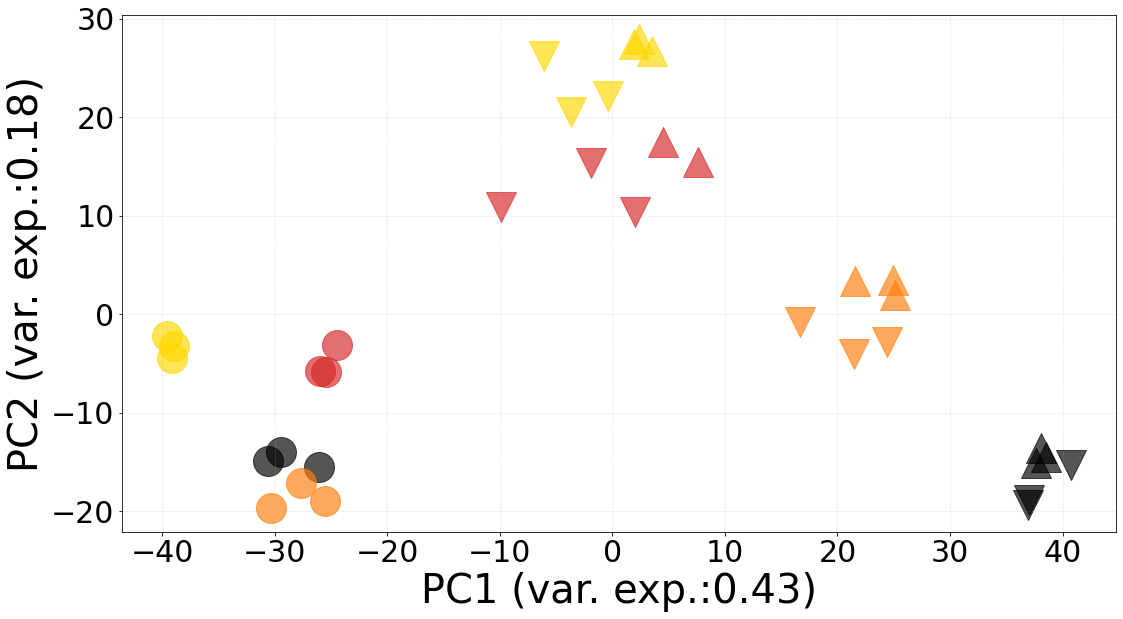

In [90]:
for i in range(len(new)):
    matplotlib.pyplot.scatter(new[i,0], new[i,1], s=900, c=the_colors[i], marker=the_markers[i], alpha=2/3)

matplotlib.pyplot.xlabel('PC1 (var. exp.:{0:.2f})'.format(explainedVar[0]))
matplotlib.pyplot.ylabel('PC2 (var. exp.:{0:.2f})'.format(explainedVar[1]))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.tight_layout()

conclusion 1. 48 and  72 are very similar, within each phenotype.
quite some variability in mutants at time zero. More than 48 and 72 hours for wt for example.


In [92]:
import umap


In [93]:
reducer = umap.UMAP()


In [94]:
embedding = reducer.fit_transform(scaled_data)


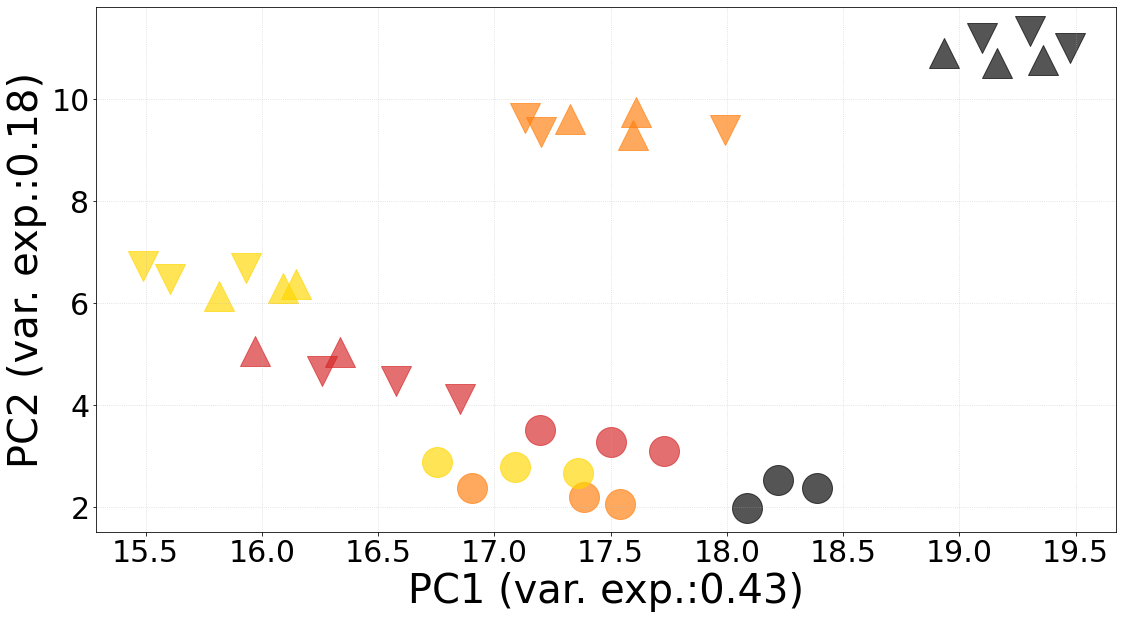

In [95]:
for i in range(len(new)):
    matplotlib.pyplot.scatter(embedding[i,0], embedding[i,1], s=900, c=the_colors[i], marker=the_markers[i], alpha=2/3)

matplotlib.pyplot.xlabel('PC1 (var. exp.:{0:.2f})'.format(explainedVar[0]))
matplotlib.pyplot.ylabel('PC2 (var. exp.:{0:.2f})'.format(explainedVar[1]))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.tight_layout()

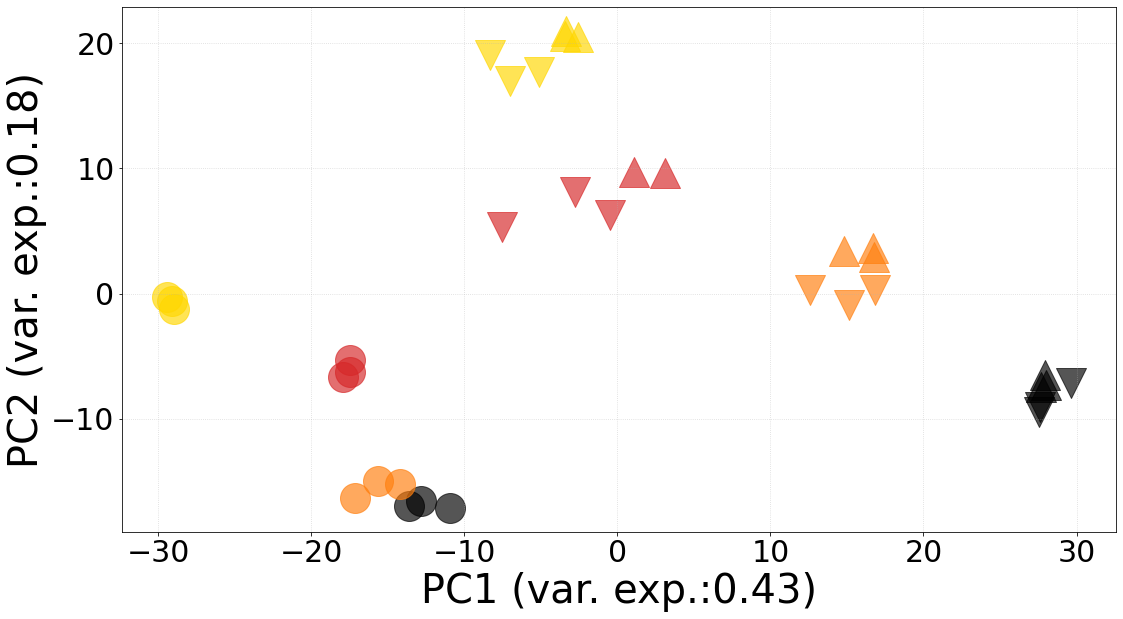

In [91]:
new = sklearn.decomposition.PCA(n_components=2).fit_transform(pca_tpms)

for i in range(len(new)):
    matplotlib.pyplot.scatter(new[i,0], new[i,1], s=900, c=the_colors[i], marker=the_markers[i], alpha=2/3)

matplotlib.pyplot.xlabel('PC1 (var. exp.:{0:.2f})'.format(explainedVar[0]))
matplotlib.pyplot.ylabel('PC2 (var. exp.:{0:.2f})'.format(explainedVar[1]))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.tight_layout()